On final dataset, using only labeled images ; Resnet18 -> Linear

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image
import random
import cv2
import progressbar
import time
import os

In [2]:
df = pd.read_pickle("data/dataset.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8090 entries, 0 to 8089
Data columns (total 3 columns):
image      8090 non-null object
points     8090 non-null object
labeled    8090 non-null int64
dtypes: int64(1), object(2)
memory usage: 189.7+ KB


In [3]:
# Removing the labeled column and unlabeled rows
todrop = []
for i in range(len(df)):
    if df.iloc[i].labeled == 0:
        todrop.append(i)
df = df.drop(index=todrop)
df = df.drop(columns=['labeled'])
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 2 columns):
image     5576 non-null object
points    5576 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
# drop the image data that is not found in folder
drop_indx = []
for i in range(len(df)):
  img = df.iloc[i].image
  if not os.path.isfile(img):
    drop_indx.append(i)
df = df.drop(drop_indx)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5576 entries, 0 to 5575
Data columns (total 2 columns):
image     5576 non-null object
points    5576 non-null object
dtypes: object(2)
memory usage: 130.7+ KB


### Utilities

In [5]:
def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp

def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes

def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def crop_boxes(boxes, im_sizes):
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes = xywh_to_x1y1x2y2(boxes)
    zero = torch.Tensor([0])
    boxes[:, 0] = torch.max(torch.min(boxes[:, 0], im_sizes[:, 0]), zero)
    boxes[:, 1] = torch.max(torch.min(boxes[:, 1], im_sizes[:, 1]), zero)
    boxes[:, 2] = torch.max(torch.min(boxes[:, 2], im_sizes[:, 0]), zero)
    boxes[:, 3] = torch.max(torch.min(boxes[:, 3], im_sizes[:, 1]), zero)
    boxes = x1y1x2y2_to_xywh(boxes)
    return boxes

def box_transform(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = 2 * boxes[:, 0] / im_sizes[:, 0] - 1
    boxes[:, 1] = 2 * boxes[:, 1] / im_sizes[:, 1] - 1
    boxes[:, 2] = 2 * boxes[:, 2] / im_sizes[:, 0]
    boxes[:, 3] = 2 * boxes[:, 3] / im_sizes[:, 1]
    return boxes

def box_transform_inv(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = (boxes[:, 0] + 1) / 2 * im_sizes[:, 0]
    boxes[:, 1] = (boxes[:, 1] + 1) / 2 * im_sizes[:, 1]
    boxes[:, 2] = boxes[:, 2] / 2 * im_sizes[:, 0]
    boxes[:, 3] = boxes[:, 3] / 2 * im_sizes[:, 1]
    return boxes

def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes1 = xywh_to_x1y1x2y2(boxes1)
    boxes2 = to_2d_tensor(boxes2)
    boxes2 = xywh_to_x1y1x2y2(boxes2)
    
    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert((a1 + a2 - ia <= 0).sum() == 0)
    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, im_sizes, theta=0.75):
    preds = box_transform_inv(preds.clone(), im_sizes)
    preds = crop_boxes(preds, im_sizes)
    targets = box_transform_inv(targets.clone(), im_sizes)
    IoU = compute_IoU(preds, targets)
    corr = (IoU >= theta).sum()
    return corr / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

### Image Transform

In [6]:
class ResizeAspect(object):
    def __init__(self, h, w):
        self.rescale_factor=None
        self.shift_w=None
        self.shift_h=None
        self.hw = (h, w)
        
    def do_image(self,img):
        h, w = self.hw
        img_h, img_w = img.shape[0], img.shape[1]
        rescale_factor = min(w/img_w, h/img_h)
        new_w = int(img_w * rescale_factor)
        new_h = int(img_h * rescale_factor)
        resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)

        canvas = np.full((h, w, 3), 128, dtype=np.uint8)
        shift_h = (h-new_h)//2
        shift_w = (w-new_w)//2
        canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
        img = canvas.copy()
        self.rescale_factor=rescale_factor
        self.shift_h = shift_h
        self.shift_w = shift_w
        return img
    
    def do_box(self, box):
#         if self.rescale_factor is None:
#             print('The image is not scaled, do_image first!!')
#             return
        box = box.reshape(-1,2)
        box *=self.rescale_factor
        box[: ,0] += self.shift_w
        box[: ,1] += self.shift_h
        box = box.reshape(-1)
        return box
    
    def undo_box(self, box):
        box = box.reshape(-1,2)
        box[: ,0] -= self.shift_w
        box[: ,1] -= self.shift_h
        box /=self.rescale_factor
        box = box.reshape(-1)
        return box
    
    
# class ImageData(object):
    
#     def __init__(self, img_dir, box):
#         self.img_dir = img_dir
#         self.box = box
#         self.img = None
#         self._load_img()
        
#     def _load_img(self):
#         self.img = Image.open(self.img_dir).convert('RGB')
#         self.img = np.array(img)

In [7]:
class FinalTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    
    def transform_inv(self,img):
        inp = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp

### Dataset Loader

In [8]:
class LicenseDataset(Dataset):
    def __init__(self, df):
        
        self.imgs = list(df.image)
        self.boxes = df.points.tolist()
#         self.labeled = df.labeled.tolist()
        self.final_transform = FinalTransform()
        self.transform = self.final_transform.transform
#         self.transform = transforms.Compose([
# #                 transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
#         ])
        
    def transform_inv(self,img):
        inp = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp
            
    def __getitem__(self, index):
        path= self.imgs[index]
        box = self.boxes[index]
        
        img = Image.open(path).convert('RGB')
        resizer = ResizeAspect(h=224, w=224)
        img = resizer.do_image(np.array(img))
        img = self.final_transform.transform(img)
        box = resizer.do_box(box)
        box = np.array(box, dtype=np.float32)
        
#         return img, box , resizer
        return img, box
      
    
    def __len__(self):
        return len(self.imgs)

In [9]:
def train_test_split(df, test_size=0.1):
    if isinstance(test_size, float):
        test_size = int(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

In [10]:
train_df, test_df = train_test_split(df, test_size=0.1)

In [11]:
train = LicenseDataset(train_df)
test = LicenseDataset(test_df)

In [12]:
# ind = random.choice(range(len(train_df)))
# img, box, img_size = train[ind]

# box = np.append(box, box[:2]).reshape(-1,2)
# img = train.final_transform.transform_inv(img)

# plt.imshow(img)
# plt.plot(box[:,0], box[:,1], lw=3, c='g')

In [13]:
train_loader = torch.utils.data.DataLoader(
                train, batch_size=32,shuffle=True,
                num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
                test, batch_size=32,shuffle=False,
                num_workers=2, pin_memory=True)

### Defining Model

In [14]:
model = models.resnet18(pretrained=True)
'''
output of our model is :
x1, y1,
x2, y2,
x3, y3,
x4, y4,
conf -> only when no bounding box images are taken
'''
num_feature = model.fc.in_features
num_output = 8#9
model.fc = nn.Linear(num_feature, num_output)
# model.eval()
# model.train()
model = model.cpu()

In [15]:
model.load_state_dict(torch.load('saved_states/model_state_v0.pth', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# criterion = nn.SmoothL1Loss().cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
# best_model_state = model.state_dict()
# best_epoch = -1
# best_acc = 0.0

# epoch_loss = {True: [], False: []}
# epoch_acc = {True: [], False: []}
# epochs = 20

In [20]:
# for epoch in range(epochs):
#     accs = AverageMeter()
#     losses = AverageMeter()
#     for train_mode in (True, False):
#         if train_mode:
#             scheduler.step()
#             data_loader = train_loader
#         else:
#             data_loader = test_loader
#         model.train(mode=train_mode)
            
#         end = time.time()
#         bar = progressbar.ProgressBar()
#         for ims, boxes in bar(data_loader):
            
#             inputs = ims.cuda()
#             targets = boxes.cuda()
            
#             optimizer.zero_grad()
            
#             # forward
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
# #             acc = compute_acc(outputs.data.cpu(), targets.data.cpu(), im_sizes)
            
#             nsample = inputs.size(0)
# #             accs.update(acc, nsample)
#             losses.update(loss.data, nsample)
            
#             if train_mode:
#                 loss.backward()
#                 optimizer.step()
        
# #         if not train_mode and accs.avg > best_acc:
# #             best_acc = accs.avg
# #             best_epoch = epoch
# #             best_model_state = model.state_dict()
            
#         elapsed_time = time.time() - end
#         print('[{}]\tEpoch: {}/{}\tLoss: {:.4f}\tAcc: {:.2%}\tTime: {:.3f}'.format(
#             train_mode, epoch+1, epochs, losses.avg, accs.avg, elapsed_time))
#         epoch_loss[train_mode].append(losses.avg)
#         epoch_acc[train_mode].append(accs.avg)
        
#     print('[Info] best test acc: {:.2%} at {}th epoch'.format(best_acc, best_epoch))
#     torch.save(model.state_dict(), 'saved_states/model_state_v0.pth')

100% (157 of 157) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


[True]	Epoch: 1/20	Loss: 80.0493	Acc: 0.00%	Time: 67.981


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 1/20	Loss: 74.2954	Acc: 0.00%	Time: 7.327
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


[True]	Epoch: 2/20	Loss: 8.8320	Acc: 0.00%	Time: 66.926


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 2/20	Loss: 8.4276	Acc: 0.00%	Time: 7.136
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


[True]	Epoch: 3/20	Loss: 4.5958	Acc: 0.00%	Time: 67.448


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 3/20	Loss: 4.5290	Acc: 0.00%	Time: 7.055
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


[True]	Epoch: 4/20	Loss: 3.4319	Acc: 0.00%	Time: 69.837


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 4/20	Loss: 3.3529	Acc: 0.00%	Time: 7.347
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


[True]	Epoch: 5/20	Loss: 2.7296	Acc: 0.00%	Time: 67.058


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 5/20	Loss: 2.5953	Acc: 0.00%	Time: 7.027
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:04 Time:  0:01:04


[True]	Epoch: 6/20	Loss: 2.4654	Acc: 0.00%	Time: 65.054


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 6/20	Loss: 2.3599	Acc: 0.00%	Time: 6.855
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


[True]	Epoch: 7/20	Loss: 2.5389	Acc: 0.00%	Time: 64.936


100% (18 of 18) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


[False]	Epoch: 7/20	Loss: 2.4191	Acc: 0.00%	Time: 6.727
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


[True]	Epoch: 8/20	Loss: 2.2717	Acc: 0.00%	Time: 64.731


100% (18 of 18) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


[False]	Epoch: 8/20	Loss: 2.1710	Acc: 0.00%	Time: 6.670
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


[True]	Epoch: 9/20	Loss: 2.1630	Acc: 0.00%	Time: 67.425


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 9/20	Loss: 2.0638	Acc: 0.00%	Time: 7.167
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


[True]	Epoch: 10/20	Loss: 2.1572	Acc: 0.00%	Time: 67.895


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 10/20	Loss: 2.0601	Acc: 0.00%	Time: 7.187
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


[True]	Epoch: 11/20	Loss: 2.1516	Acc: 0.00%	Time: 67.385


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 11/20	Loss: 2.0609	Acc: 0.00%	Time: 7.413
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:07 Time:  0:01:07


[True]	Epoch: 12/20	Loss: 2.0907	Acc: 0.00%	Time: 68.917


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 12/20	Loss: 1.9911	Acc: 0.00%	Time: 7.304
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


[True]	Epoch: 13/20	Loss: 2.1189	Acc: 0.00%	Time: 70.415


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 13/20	Loss: 2.0820	Acc: 0.00%	Time: 7.341
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


[True]	Epoch: 14/20	Loss: 2.2654	Acc: 0.00%	Time: 69.468


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 14/20	Loss: 2.1467	Acc: 0.00%	Time: 7.366
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


[True]	Epoch: 15/20	Loss: 2.0918	Acc: 0.00%	Time: 70.042


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 15/20	Loss: 1.9907	Acc: 0.00%	Time: 7.392
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


[True]	Epoch: 16/20	Loss: 2.1184	Acc: 0.00%	Time: 70.832


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 16/20	Loss: 2.0148	Acc: 0.00%	Time: 7.503
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


[True]	Epoch: 17/20	Loss: 2.0338	Acc: 0.00%	Time: 69.748


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 17/20	Loss: 1.9395	Acc: 0.00%	Time: 7.457
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


[True]	Epoch: 18/20	Loss: 2.0723	Acc: 0.00%	Time: 69.271


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 18/20	Loss: 1.9888	Acc: 0.00%	Time: 7.334
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


[True]	Epoch: 19/20	Loss: 2.0758	Acc: 0.00%	Time: 70.026


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 19/20	Loss: 1.9820	Acc: 0.00%	Time: 7.380
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


[True]	Epoch: 20/20	Loss: 2.1165	Acc: 0.00%	Time: 69.468


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 20/20	Loss: 2.0180	Acc: 0.00%	Time: 7.539
[Info] best test acc: 0.00% at -1th epoch


In [16]:
test_batch = 0
indx = -1
model.eval()
print('Working in test mode')

Working in test mode


2


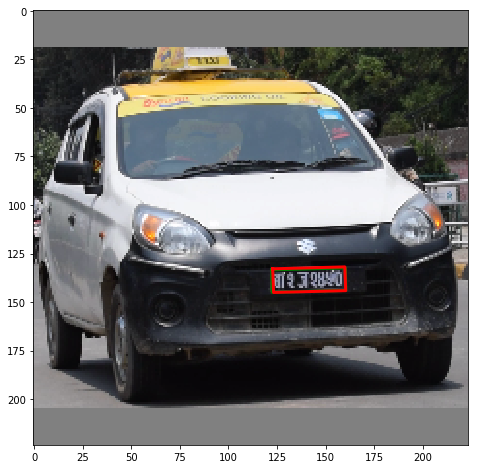

In [115]:
if indx < 0:
  # model.train(mode=False)
  for i,(ims, boxes) in enumerate(test_loader):
    if i<test_batch:
      continue
    inputs = ims.cpu()
    targets = boxes.cpu()
    outputs = model(inputs)
    test_batch +=1
    break
    
indx +=1
img = inputs[indx].data.cpu()
img = FinalTransform().transform_inv(img)
out = outputs[indx].data.cpu().numpy()
out = np.append(out, out[:2]).reshape(-1,2)
targ = targets[indx].data.cpu().numpy()
targ = np.append(targ, targ[:2]).reshape(-1,2)


plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.plot(targ[:,0], targ[:,1], lw=3, c='g')
plt.plot(out[:,0], out[:,1], lw=3, c='r')
print(indx)
if indx == 31:
  indx = -1

In [0]:
# model_state = model.state_dict()
# torch.save(model_state, 'saved_states/model_state_v0.pth')
# # optimizer_state = optimizer.state_dict()
# # torch.save(optimizer_state, 'saved_states/optimizer_state_v0.pth')
# # model.load_state_dict(torch.load('saved_states/model_state_v0.pth'))